In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat
from scipy.sparse import bsr_matrix

from geo_annulus import *
#from multipatch_block_handler import *
from plots import *
from ass_nonlin_el import *
from solver import *
from line_search import *


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
 no MKL


In [2]:
p = 3  # spline degree 
x_el= 24
y_el= 4
n_el = (x_el, y_el) #  isotropic material
# displacement space: degree p,   continuity p-1
multi= 1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
#m_u = tuple(kv.numdofs for kv in kvs_u)
#kvs_ref= tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi).refine() for n in n_el)

In [3]:
r_in = 1.93 #mm
r_out = 2.25 #mm
geos = geo_annulus(r_in, r_out)

In [4]:
patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True)

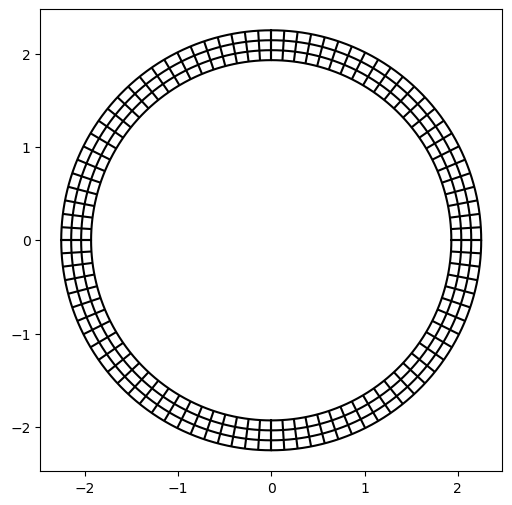

In [5]:

fig, ax = plt.subplots(figsize=(8,6))
for g in geos:
    vis.plot_geo(g, gridx=np.linspace(0, 1, x_el), gridy=np.linspace(0, 1, y_el))
ax.axis('scaled');


In [6]:
## set blocks for x and y component

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )


In [7]:
# source term f 
def f(x, y): return (0.0, 0.0)

#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
def gN(x, y): 
    return (x/r_in*l_val, y/r_in*l_val)  #inner  pressure, normalized vector

# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)


# Robin BC
def g_robin(x, y): return 0 # hom. Robin bd cond
    #return ( 1-(x/r_out+ y/r_out)**2) # scalar value
    

In [8]:

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero ) 
])


In [9]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [10]:
#incremental loading
# pressure: 13.33 kPa --> 100mmHg
#           10.664 kPa --> 80mmHg
# p_int:    2.666 kPa ---> 20mmHg
maxload = 2.666e-3# 5.666e-3#2.666e-3 #1.5e-3 #13.33*1e-3 #1.5e-2 #2e-3
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [11]:
#alpha =1e-2# 1.5e3# 1e0 # 1e4 max penalization!

def alpha(x, y): return ( 1-(x/r_out+ y/r_out)**2) * 1e-2 # scalar value

robin_data = [(1, 'right', g_robin, alpha)] # instead of Dirichlet-bdc, outer bd fixed

#robin_data = [(1, 'right', g_zero, 1)] # instead of Dirichlet-bdc, outer bd fixed

In [12]:
# assemble Robin-matrix
AR = ass_Robin(MP_block, robin_data)

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod39620131bb952563.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod39620131bb952563.pyx


In [13]:
def J(u):
    return ass_energy(u, MP_block, kvs_j, neu_data, robin_data)


def grad_J(u):
    return -ass_rhs_RN(u, MP_block, neu_data, AR)


use SuperLU
Residual0 = 0.011230477093812908
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod37788c923234b795.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod37788c923234b795.pyx
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modb35959389fcad404.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modb35959389fcad404.pyx
Energy0   = 0.0
use SuperLU
Error= 0.117379333952388
Energy    = -0.005505061497736947


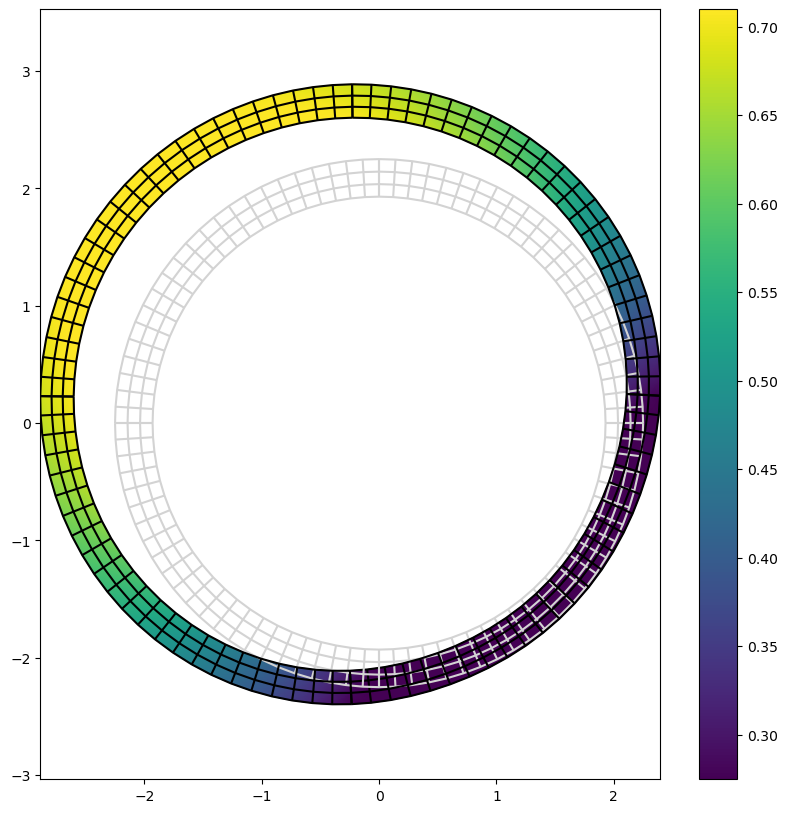

In [16]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

### first iteration ###
A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR) # with Robin-matrix
#S,sig= ass_cauchystress(u, MP_block) 

M = ass_mass(MP_block)
Minv = make_solver(M)

r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(A).dot(b) 
u += u_d

w= np.inner(np.transpose(u_d),b)
err = np.sqrt(np.abs(w))
print('Error=', err)

#A, b = ass_nonlinsystem(u, MP_block, neu_data, AR) 
#b= ass_rhs_RN( u, MP_block, neu_data, AR)
#print('rhs:', b)

#r = np.transpose(b).dot(Minv.dot(b)) #L2-norm
#print('Residual  =', r)
print('Energy    =', J(u))



###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

 
 
 1. loading: 0.0008886666666666666 

0
Energy   = 0.0
Error= 0.03912644465079577
1
Energy   = -0.0007174070081469247
Error= 0.0037458857892800315
2
Energy   = -0.0007244939635621052
Error= 0.00010891989277581468
3
Energy   = -0.0007245000249881509
Error= 3.9011313705875776e-07
4
Energy   = -0.0007245000254412597
Error= 5.184627776544065e-12
u=  [0.05040111 0.04922671 0.04701399 ... 0.07917474 0.07912266 0.07909655]
 
 
 2. loading: 0.0017773333333333335 

0
Energy   = -0.002136987842885964
Error= 0.036202062938984314
1
Energy   = -0.002762169714596079
Error= 0.0026250190845606347
2
Energy   = -0.002765623148294931
Error= 1.2979641649922257e-05
3
Energy   = -0.0027656232060487033
Error= 6.043312557107801e-10
4
Energy   = -0.0027656232060483932
Error= 1.7653540348808772e-16
u=  [0.09347428 0.09110899 0.08668693 ... 0.14950085 0.14940147 0.14935163]
 
 
 3. loading: 0.002666 

0
Energy   = -0.005410908823649011
Error= 0.03411117375564007
1
Energy   = -0.005971698755733536
Error= 0.002

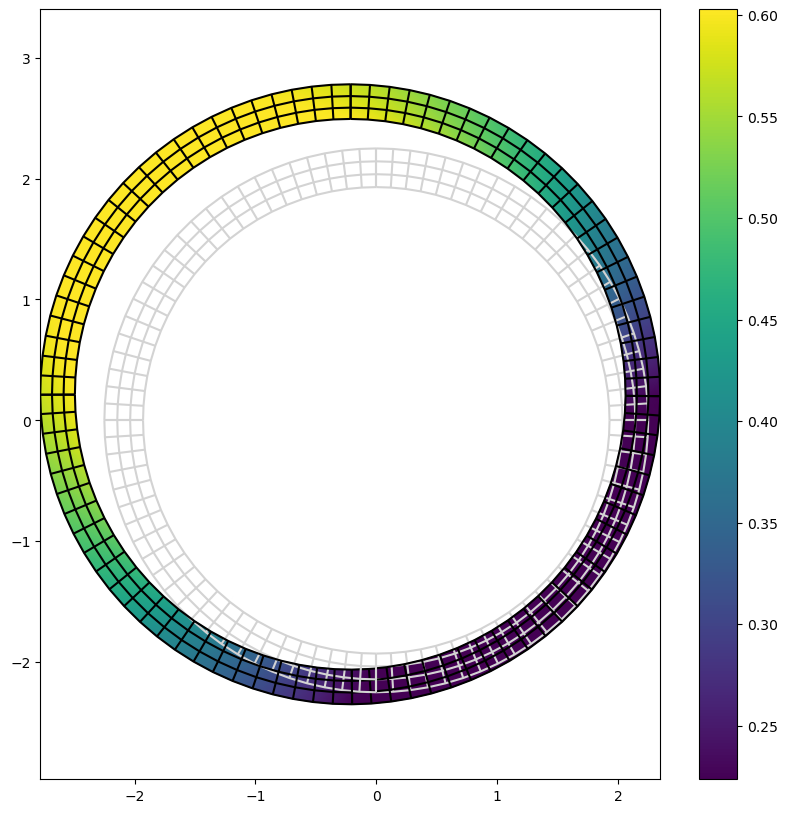

In [15]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []
vol= []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while True:
        print(count)
        
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        print('Energy   =',J(u))
        u_d = make_solver(A).dot(b)
        ## error measure in H1*
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)
        
        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if abs(err) < max_err:
            break
        elif count == 20:
            break
        
        count+=1
        #update solution
        u += u_d  
        
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
    
    loc_vol= local_vol (u, MP_block)
    vol.append(loc_vol)
    
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [16]:
sum(iter_counts)

12

4it [00:00,  4.08it/s]                                                                                                                                      


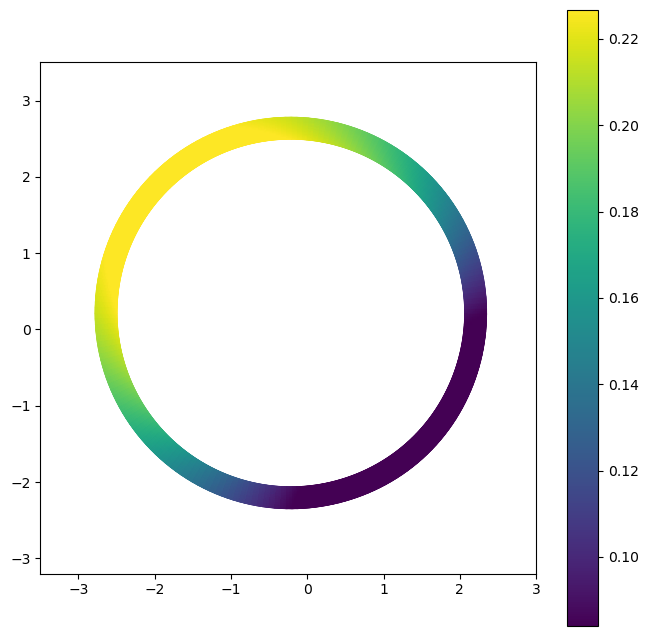

In [17]:
from IPython.display import HTML

figsize(14, 4)
s_sol= shape(solutions)[0]
fields = [solutions[tt] for tt in range(s_sol)]
HTML(animate_field(fields, patches_u, kvs_u, MP_u, res=(50,70), interval=635, progress=True).to_html5_video())

 
 
 1. loading: 0.0008886666666666666 

1
Residual = 0.0012478307882014344
Energy   = 0.0
use SuperLU
Error= 0.039126444650796
 
 
 2. loading: 0.0017773333333333335 

1
Residual = 0.0021745644458830648
Energy   = -0.0022484024943417503
use SuperLU
Error= 0.0327195173080025
 
 
 3. loading: 0.002666 

1
Residual = 0.0019617668453933926
Energy   = -0.005468101204075955
use SuperLU
Error= 0.032264357809133636
residual = 8.363634642270356e-05
energy   = -0.005972105354350081
use SuperLU
Error= 0.0018473095919059994
1
residual = 7.838523234557407e-10
energy   = -0.005973813987216241
use SuperLU
Error= 9.81549434135598e-06
2
residual = 3.432751981844119e-17
energy   = -0.005973814040550016
use SuperLU
Error= 1.115468515076647e-09
3
residual = 3.133075059051722e-29
energy   = -0.005973814040551544
use SuperLU
Error= 2.900873851235947e-16
u=  [0.13285709 0.12926209 0.12259386 ... 0.21220493 0.21207795 0.21201424]


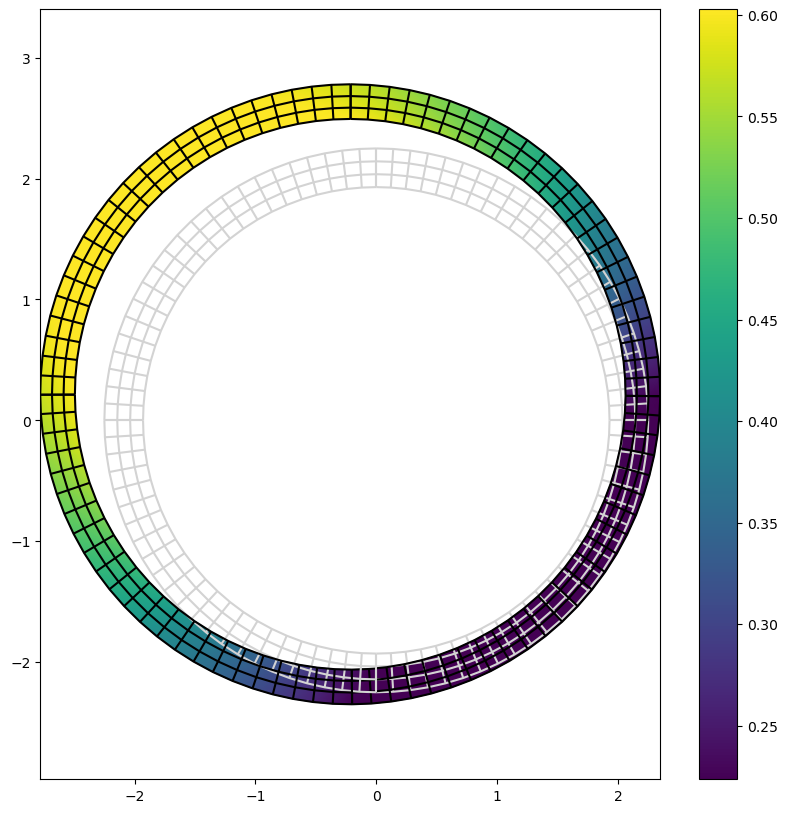

In [17]:

#initial value
u= np.zeros(dd)
u_d= u

epsilon= 1e-11# 1e-5
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while count <len(loading)-2:
        count+=1
        print(count)
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
       
        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(A).dot(b)
        u += u_d  
        
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)
        
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        

    solutions.append(np.array(u))
    iter_counts.append(count)
    count=0

# solve solution exact on max. loading 
while True:
    A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
    r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm

    print('residual =', r)
    print('energy   =', J(u))
    
    # # solve system # #
    u_d = make_solver(A).dot(b)
    
    w= np.inner(np.transpose(u_d),b)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 20:
        break
    
    count+=1 # count only, when system is solved
    print(count)
    # update u
    u += u_d 
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#
    
ud_array.append(u_d) 
print('u= ' , u)
solutions.append(np.array(u))
iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [18]:
sum(iter_counts)

6


 patch: 0
inner radius_0= 2.072517082517603
outer radius_0= 2.3578498967653885
displacement_inner= [0.13260463 0.20245794]
displacement_outer= [0.09932473 0.20032339]
dis_inner_x/dis_outer_x:  1.3350615652339537
dis_inner_y/dis_outer_y:  1.0106554762144977
 ratio_inner: 1.073843047936582
 ratio_outer: 1.0479332874512837

 patch: 1
inner radius_0= 2.072517082517604
outer radius_0= 2.357849896765389
displacement_inner= [-0.20245794 -0.13260463]
displacement_outer= [-0.20032339 -0.09932473]
dis_inner_x/dis_outer_x:  1.0106554762144986
dis_inner_y/dis_outer_y:  1.335061565233952
 ratio_inner: 1.0738430479365824
 ratio_outer: 1.047933287451284

 patch: 2
inner radius_0= 2.503052052660109
outer radius_0= 2.7888971384219245
displacement_inner= [-0.56399199  0.21277584]
displacement_outer= [-0.53082671  0.21201424]
dis_inner_x/dis_outer_x:  1.0624785276498565
dis_inner_y/dis_outer_y:  1.003592198744865
 ratio_inner: 1.2969181620000565
 ratio_outer: 1.2395098392986332

 patch: 3
inner radius_0

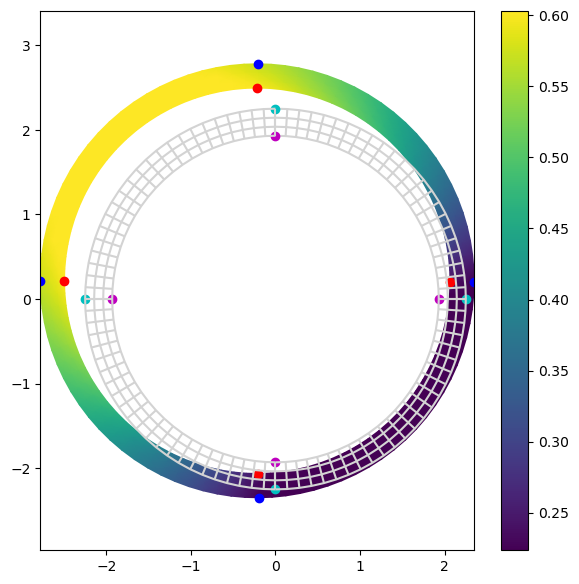

In [19]:
get_defplotPP(u, patches_u, kvs_u, MP_u, n_el, r_in, r_out)

In [20]:
iter_counts

[1, 1, 1, 3]

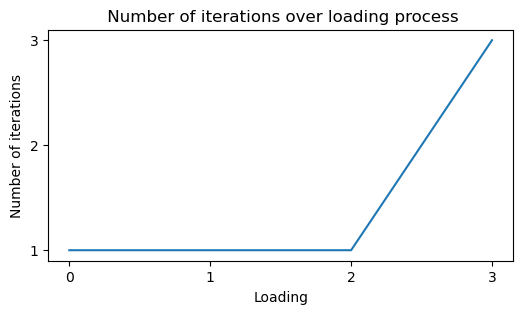

In [21]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [22]:
cs = cauchystress(u, MP_block)

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\moda93ca87894961319.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\moda93ca87894961319.pyx
use SuperLU


In [23]:
max(cs)

0.0004373854430304584

In [24]:

# for scalar-valued input vector
def get_defplot_scalar_cs(a, u, patches_u, kvs_u, MP_u, n_el, geos):
    ## use refined knot vectors
    #patches_ref = [(kvs_ref, g) for g in geos]
    #MP_ref = assemble.Multipatch(patches_ref, automatch=True)
    
    """Split solution vector into displacement components."""
    u_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ a)
               for p in range(len(patches_u))]
    u1_funcs, u2_funcs = split_u(u, MP_u, kvs_u, patches_u)
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    
    xgrid=np.linspace(0, 1, x_el)
    ygrid=np.linspace(0, 1, y_el)
    xygrid = (xgrid, ygrid)
    vrange= None

    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (u1_func, u2_func, u_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        G = geo.grid_eval(xygrid)
        scale = u_func.grid_eval(xygrid) #x-value
        C  = scale
        #plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey")
        #plot_grid(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], ax=ax, color="black")
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
    plt.colorbar();
    plt.axis('equal')
    plt.savefig('rob2d_cs.png')
    
    

use SuperLU


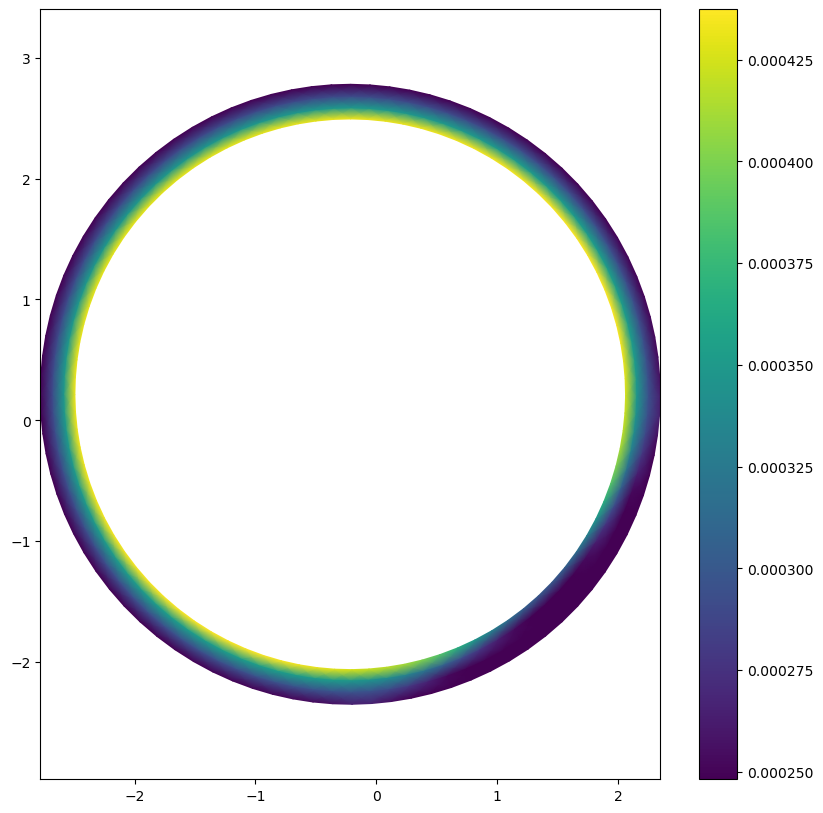

In [25]:
# Cauchy-stress
get_defplot_scalar_cs(cauchystress(u, MP_block), u, patches_u, kvs_u, MP_u, n_el, geos)

In [26]:

# for scalar-valued input vector
def get_defplot_scalar_vol(a, u, patches_u, kvs_u, MP_u, n_el, geos):
    ## use refined knot vectors
    #patches_ref = [(kvs_ref, g) for g in geos]
    #MP_ref = assemble.Multipatch(patches_ref, automatch=True)
    
    """Split solution vector into displacement components."""
    u_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ a)
               for p in range(len(patches_u))]
    u1_funcs, u2_funcs = split_u(u, MP_u, kvs_u, patches_u)
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    
    xgrid=np.linspace(0, 1, x_el)
    ygrid=np.linspace(0, 1, y_el)
    xygrid = (xgrid, ygrid)
    vrange= None

    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (u1_func, u2_func, u_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        G = geo.grid_eval(xygrid)
        scale = u_func.grid_eval(xygrid) #x-value
        C  = scale
        #plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey")
        #plot_grid(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], ax=ax, color="black")
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
    plt.colorbar();
    plt.axis('equal')
    plt.savefig('rob2d_vol.png')
    
    

use SuperLU


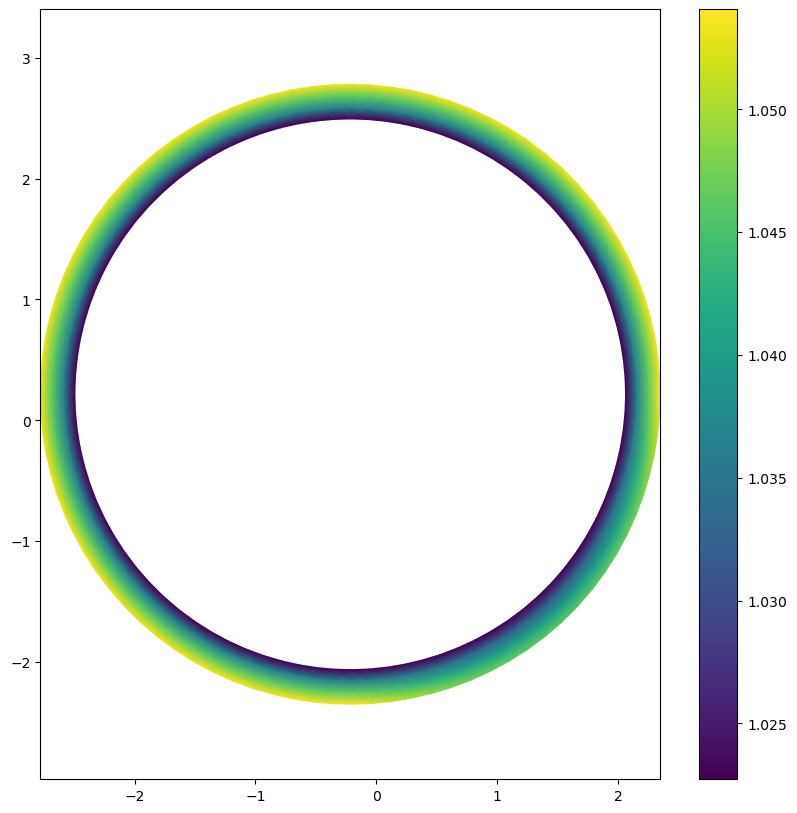

In [27]:
# local volume
get_defplot_scalar_vol(local_vol(u, MP_block),u, patches_u, kvs_u, MP_u, n_el, geos)

use SuperLU
use SuperLU

 patch: 0
cauchystress_inner= 0.0004259757144688123
cauchystress_outer= 0.0002638898852417121
volume_inner= 1.0227217933218964
volume_outer= 1.0540763679321359

 patch: 2
cauchystress_inner= 0.00043248685929036314
cauchystress_outer= 0.00024822278161645356
volume_inner= 1.0227542453534335
volume_outer= 1.0533015554712155


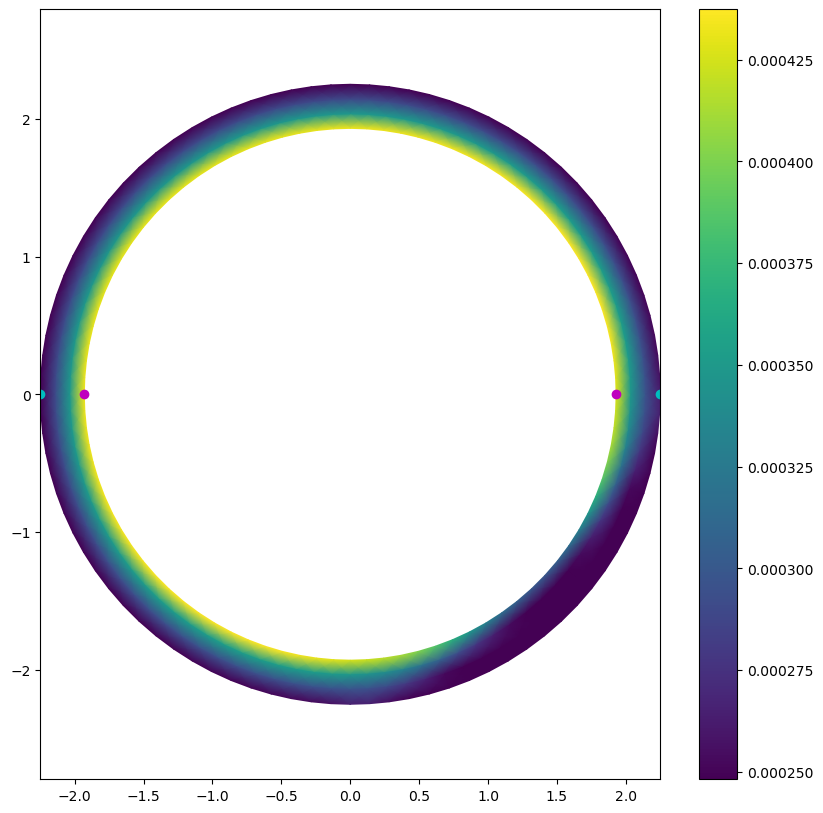

In [28]:
get_defplot_evalp(cauchystress(u, MP_block), local_vol(u, MP_block), patches_u, kvs_u, MP_u, n_el)

In [ ]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []
vol= []

print(" without loading\n")

# set Neumann data via incremental loading
l_val = loading[-1]
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

count = 0
while True:
    print(count)
    A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
    print('Energy   =',J(u))
    u_d = make_solver(A).dot(b)
    
    ## error measure in H1*
    w= np.inner(np.transpose(u_d),b)
    err = np.sqrt(np.abs(w))
    print('Error=', err)

    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#

    #if r < epsilon * r0: # break condition
    if abs(err) < max_err:
        break
    elif count == 20:
        break
        
    count+=1
    u += u_d  

ud_array.append(u_d) 
print('u= ' , u)
solutions.append(np.array(u))
iter_counts.append(count)

loc_vol= local_vol (u, MP_block)
vol.append(loc_vol)
       
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [ ]:
sum(iter_counts)

In [ ]:
vol_ratio= global_vol (u, MP_block, kvs_j)

In [ ]:
vol_ratio

In [ ]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

    dis = get_components(X.T @ u, kvs_ux)
    detF= sum(assemble.assemble( '(tr(grad(dis))+2)  * aux * dx',kvs_ux, bfuns=[('aux',1)], geo=geo_ux, dis=dis).ravel())
    print(detF)

In [ ]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
    kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration
    dis = get_components(X.T @ u, kvs_ux)
    #print(dis)
    detF= sum(assemble.assemble( '((1+grad(dis)[0,0]) *(1+grad(dis)[1,1])-grad(dis)[0,1]*grad(dis)[1,0])* aux * dx',kvs_j, bfuns=[('aux',1)], geo=geo_ux, dis=dis).ravel())
    print(detF)

In [ ]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
    kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration
    dis = get_components(X.T @ u, kvs_ux)
    detF= sum(assemble.assemble( '((1+grad(dis)[0,0]) *(1+grad(dis)[1,1]))* aux * dx',kvs_j, bfuns=[('aux',1)], geo=geo_ux, dis=dis).ravel())
    print(detF)

In [ ]:
vol_ratio= global_vol(u, MP_block, kvs_j)

In [ ]:
vol_ratio

In [ ]:
r_in*r_in *np.pi

In [ ]:
r_out*r_out *np.pi

In [ ]:
def vol_undef(r_inner=r_in, r_outer=r_out):
    return (r_outer**2 - r_inner**2) *np.pi

In [ ]:
vol_undef()

In [ ]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

epsilon= 1e-11# 1e-5
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
#M = ass_mass(MP_block)
#Minv = make_solver(M)
r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
#r0 = np.linalg.norm(b)


print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while count <len(loading)-2:
        count+=1

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
            r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
            print('Residual =',r)
            print('Energy   =',J(u))
        #else: # Use from last iteration; see below (*)
            
        print(count)

        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(A).dot(b)
        u += u_d          

        # Compute new non-linear residual, already to be used for next iteration (*)
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
            
        print('residual =', r)
        print('energy   =', J(u))
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)
        
        
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
    solutions.append(np.array(u))
    iter_counts.append(count)
    count=0

while True:
    count+=1

    # Assemble matrices and rhs in every iteration step
#     if count == 1:
#         A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
#         r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
#         print('Residual =',r)
#         print('Energy   =',J(u))
    #else: # Use from last iteration; see below (*)
    print(count)

    # # solve system # #
    u_d = make_solver(A).dot(b)
    u += u_d          

    # Compute new non-linear residual, already to be used for next iteration (*)
    A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
    r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm

    print('residual =', r)
    print('energy   =', J(u))

    w= np.inner(np.transpose(u_d),b)
    err = np.sqrt(np.abs(w))
    print('Error=', err)


    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#

    #if r < epsilon * r0: # break condition
    if abs(err) < max_err:
        break
    elif count == 20:
        break
    #
ud_array.append(u_d) 
print('u= ' , u)
solutions.append(np.array(u))
iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [ ]:
plt.clf()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
res=(50,70)
#vrange=(0.0, 1.5e-3)

s_sol= shape(solutions)[0]
ims = []
ar= np.linspace(1,2, s_sol)
factor = 1

#fields = list(ud_array)
fields = list(solutions)

for tt in range(s_sol):
    #u = LS.complete(fields[tt])
    u = fields[tt]
    #factor = ar[tt] # choose factor for deformation plot
    vrange = None
    ims_q = []
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:]

    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
            for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
            for p in range(len(patches_u))]
    plt.ioff()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        im_q=[]
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            #vrange = (0.0, 1.5e-3)
            vrange = (C.min(), C.max())
        im_q = plt.pcolormesh(XY[..., 0] + factor*dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1], axes=ax) # shading for smoothing
        
        im_q.set_array(C.ravel()) 
        ims_q.append(im_q) 
    
    ims.append(ims_q)
    #print(shape(ims))
#print(ims[0])
    
#fig.colorbar(im_q, ax=ax);
colorbar();
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat= False) # repeat_delay=2000



#ani.to_html5_video()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'))
#ani.save("rtest.mp4", writer=writer )
vid = ani.to_html5_video()
# saving to m4 using ffmpeg writer
#writervideo = animation.FFMpegWriter(fps=500)
#ani.save('Robin_15.mp4', writer=writervideo)

plt.close()



In [ ]:
ani